<a href="https://colab.research.google.com/github/cmeneses1/GeokMedoidsCalculator/blob/main/k_Medoids_Elbow_Heuristic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k-Medoids elbow heuristics
-----------
This calculator runs the kMedoids algorithm for several values of the unique hyperparameter, $k$, the number of clusters. Then, it plots the elbow representation in order to asses an appropiate number of clusters.

## 1. Installing and importing dependencies
Install this required package.

In [1]:
!pip install scikit-learn-extra

     |████████████████████████████████| 1.7 MB 1.1 MB/s 


Import those required packages.

In [2]:
from geopy import distance
from sklearn_extra.cluster import KMedoids
from seaborn import color_palette
import matplotlib.pyplot as plt
import folium
import pandas as pd
import numpy as np
import requests
import json

## 2. Importing data
Loading a test data file with three columns: `Name`, `Latitude` and `Longitude`.

In [3]:
%%file test.txt
Name	Latitude	Longitude
Parajas	43.2016456	-6.585278
Noceda	43.1944265	-6.6178032
Iboyo	43.2108331	-6.6354339
Vega de Truelles, La	43.2278243	-6.5844473
Río de Villar	43.321479	-6.800871
Villar de Castanedo	43.2675174	-6.7116478
Castanedo	43.2675174	-6.7116478
Valbona	43.2617475	-6.590518
Presnas	43.2295493	-6.5761443
Trigaledo, El	43.2473996	-6.832618
Beveraso	43.2781441	-6.7986945
Cernías	43.2996843	-6.8277327
Estela	43.2950755	-6.7974456
Cabral	43.3020667	-6.7111294
Pontenova	43.27599	-6.73081
Vallinadosa	43.29101	-6.71304
Salcedo	43.2013551	-6.7615475
Paradas	43.1885	-6.8179
Busvidal	43.2005095	-6.8174364
Furada, La	43.1713428	-6.7583648
Villanueva	43.1440866	-6.7949573
Villalaín	43.1224534	-6.8133427
San Salvador	43.15547	-6.805
Pradiella	43.2400293	-6.6180261
Santa Eulalia	43.2239258	-6.598798

Writing test.txt


In [4]:
name = 'test.txt'
data = pd.read_table(name)
data

,Name,Latitude,Longitude
0,Parajas,43.201646,-6.585278
1,Noceda,43.194426,-6.617803
2,Iboyo,43.210833,-6.635434
3,"Vega de Truelles, La",43.227824,-6.584447
4,Río de Villar,43.321479,-6.800871
5,Villar de Castanedo,43.267517,-6.711648
6,Castanedo,43.267517,-6.711648
7,Valbona,43.261747,-6.590518
8,Presnas,43.229549,-6.576144
9,"Trigaledo, El",43.247400,-6.832618


## 3. Arrays of traveling distance
Now, we calculate a distance array: traveling time distance (travel by car and time in minutes), called `durations`, computed by the [OSMR API](http://project-osrm.org/docs/v5.5.1/api/?language=cURL#general-options).

In [5]:
# Longitude and Latitude vectors
Longitude = data.Longitude
Latitude = data.Latitude

# Number of locations
n = len(Longitude)

# Creating a convenient string for OSRM service
lonLatString = ''
for i in range(0, n):
    lon = Longitude[i]
    lat = Latitude[i]
    lonLatString += str(lon) + ',' + str(lat) + ';'

# Not interested in the last ';' string
lonLatString = lonLatString[0:-1]

# call the OSMR API
osmrString = "http://router.project-osrm.org/table/v1/driving/" + lonLatString 
r = requests.get(osmrString)

# Extracting driving time duration array, in minutes, and making it symmetrical
durations = 1/60 * np.array(json.loads(r.content)['durations'])
durations = 1/2 * (durations + np.transpose(durations))

## 4. The elbow method
Lets apply the elbow heuristic with `KMedoids` algorithm. First, calculate the algorithm for several number of clusters, for instance, $N=10\ (\leq n)$; then, plot the whithin sum of distances vs. the number of cluster, and look for an appropiate number of clusters, near the elbow shape.

This functions calculates the whithin cluster sum of distances.

In [6]:
def sumDecomposition(distances, medoids, labels):
    """
    This function calculates the total sum of distances, T, the sum of distances 
    within clusters, W, and the sum of distances between clusters, B.
    Arguments:
        distances: array of distances.
        medoids: list of medoid indices.
        labels: list of clustering labels.
    """
    T = 1/2 * np.sum(distances)
    W = 0
    B = 0
    for cluster in range(0, len(medoids)):
        for i, elem in enumerate(labels):
            if elem == cluster:
                for j, elem2 in enumerate(labels):
                    if elem2 == cluster:
                        W += distances[i, j]
                    else:
                        B += distances[i, j]
    W *= 1/2
    B *= 1/2
    return T, W, B

Now, apply the `KMedoids` algorithm for serveral number of clusters.

In [7]:
N = 10
w = []

for k in range(1, 1+min(n, N)):
    # Apply KMedoids function.
    kmedoids = KMedoids(n_clusters=k,
                                metric='precomputed').fit(durations)
    medoids = kmedoids.medoid_indices_
    labels = kmedoids.labels_
    T, W, B = sumDecomposition(durations,
                               medoids, labels)
    w.append(W)

/usr/local/lib/python3.7/dist-packages/sklearn_extra/cluster/_k_medoids.py:279: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.7/dist-packages/sklearn_extra/cluster/_k_medoids.py:279: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.7/dist-packages/sklearn_extra/cluster/_k_medoids.py:279: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  "its corresponding cluster ({k}).".format(k=k)


This is the plot that you need to use the elbow heuristic.

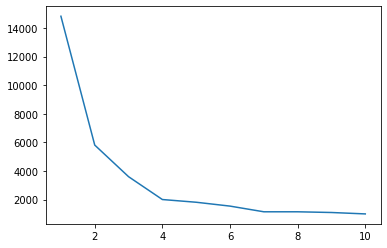

In [8]:
plt.plot(range(1, min(n, N)+1), w)

# 5. The kMedoids algorithm and map representation
After having choose an appropiate number of clusters, lets compute the `KMedoids` algorithm for the last time.

In [9]:
# Choose a number of cluster
n_clusters = 4

# Apply KMedoids function.
kmedoids = KMedoids(n_clusters=n_clusters,
                            metric='precomputed').fit(durations)
medoids = kmedoids.medoid_indices_
labels = kmedoids.labels_
T, W, B = sumDecomposition(durations, medoids, labels)
print('Medoid indices:', medoids)
print('Medoid labels:', labels)
print(f"T = {T}, W = {W}, B = {B}, W/T = {W/T}")

Medoid indices: [ 8 16 12 13]
Medoid labels: [0 0 0 0 2 1 1 0 0 2 3 2 2 3 3 3 1 1 1 1 1 1 1 0 0]
T = 14827.576666666668, W = 2004.4141666666687, B = 12823.16249999999, W/T = 0.1351815075198848


Lets represent in a map.

In [10]:
# Creates the map
f = folium.Figure(width='65%')
m = folium.Map(location=[Latitude.mean(), Longitude.mean()]).add_to(f)

# Having a touch of color.
color = color_palette("husl", n_clusters).as_hex()

# Representing our clustering medoids
for i, elem in enumerate(medoids):
    folium.Circle(
        location=[Latitude[elem], Longitude[elem]],
        radius=600,
        color=color[i],
        fill=False,
        fill_color=color[i],
    ).add_to(m)

# Representing our clustering output
for i, elem in enumerate(labels):
    folium.Circle(
        location=[Latitude[i], Longitude[i]],
        radius=200,
        popup=data.Name[i],
        color=color[elem],
        fill=True,
        fill_color=color[elem],
    ).add_to(m)

# Adjust zoom
sw = data[['Latitude', 'Longitude']].min().values.tolist()
ne = data[['Latitude', 'Longitude']].max().values.tolist()
m.fit_bounds([sw, ne]) 

m